In [2]:
import pandas as pd
import pmdarima as pm
import numpy as np
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import math
import keras
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch

from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
data=pd.read_csv('D:HistoricalData_1659419648541.csv', index_col=0)
data

,Close/Last,Volume,Open,High,Low
Date,,,,,
08/01/2022,100.03,24757.0,103.87,100.49,99.36
07/29/2022,103.97,23686.0,102.54,104.27,103.50
07/28/2022,107.14,4903.0,107.49,108.98,105.96
07/27/2022,106.62,8456.0,104.78,107.80,103.72
07/26/2022,104.40,16097.0,104.81,107.35,103.98
...,...,...,...,...,...
08/08/2012,112.14,4966.0,111.46,113.06,111.46
08/07/2012,112.00,NaN,112.00,112.00,112.00
08/06/2012,109.55,614.0,108.50,109.69,108.12


In [4]:
reverse = data[::-1]

In [5]:
df = reverse.iloc[:,:1]

In [6]:
df

,Close/Last
Date,
08/02/2012,105.90
08/03/2012,108.94
08/06/2012,109.55
08/07/2012,112.00
08/08/2012,112.14
...,...
07/26/2022,104.40
07/27/2022,106.62
07/28/2022,107.14


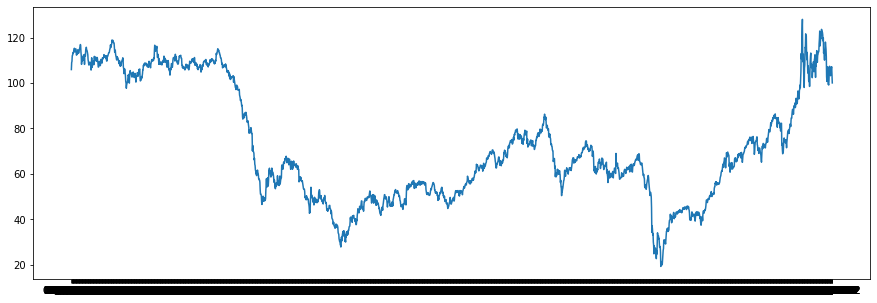

In [7]:
fig = plt.figure(figsize=[15,5])
plt.plot(df)

In [8]:
#Packages for pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

 # Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [9]:
df.shape

(2548, 1)

In [10]:
X = df[0:2547]
y = df[1:2548]

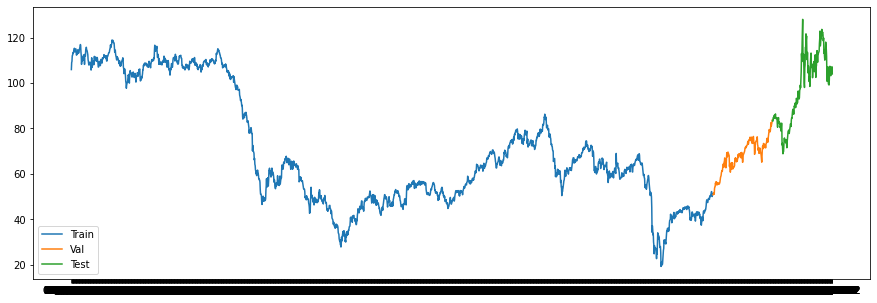

In [11]:
X_train = X[:-400]
X_test = X[-201:]
X_val = X[-400:-201]

plt.figure(figsize=(15,5))
#plt.grid()
plt.plot(X_train,label='Train')
plt.plot( X_val,label='Val')
plt.plot( X_test,label='Test')


plt.legend()
plt.show()

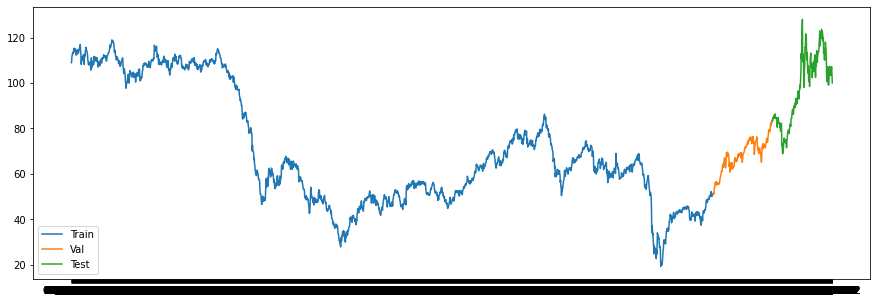

In [12]:
y_train = y[:-400]
y_test = y[-201:]
y_val = y[-400:-201]

plt.figure(figsize=(15,5))
#plt.grid()
plt.plot(y_train,label='Train')
plt.plot( y_val,label='Val')
plt.plot( y_test,label='Test')


plt.legend()
plt.show()

In [13]:
 # Feature Scaling
sc = MinMaxScaler()
X_train = np.reshape(X_train,(-1,1))
y_train = np.reshape(y_train,(-1,1))
X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)

In [14]:
len(X_train)


2147

In [15]:
X_train = np.reshape(X_train, (2147,1,1))

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=4,max_value=128,step=4),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
        model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(
        optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',metrics = ['mse'])
    return model

In [17]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1,
        directory='LSTM_RS',
        project_name='LSTM_Hyperparameter3'
        )
     

In [18]:

tuner.search(
        x=X_train,
        y=y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_val,y_val),
)

Trial 2 Complete [00h 00m 47s]
mse: 0.0008424641564488411

Best mse So Far: 0.00023671338567510247
Total elapsed time: 00h 01m 30s
INFO:tensorflow:Oracle triggered exit


In [19]:
best_model = tuner.get_best_models(num_models=1)[0]

In [20]:
best_model

In [21]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 116)            54752     
                                                                 
 lstm_1 (LSTM)               (None, 1, 96)             81792     
                                                                 
 dropout (Dropout)           (None, 1, 96)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 32)             16512     
                                                                 
 dropout_1 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 1, 32)             8320      
                                                                 
 dropout_2 (Dropout)         (None, 1, 32)             0

In [41]:
 # Fitting the RNN to the Training set
history = best_model.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

In [42]:
len(X_train)

2147

80/80 [==============================] - 1s 10ms/step


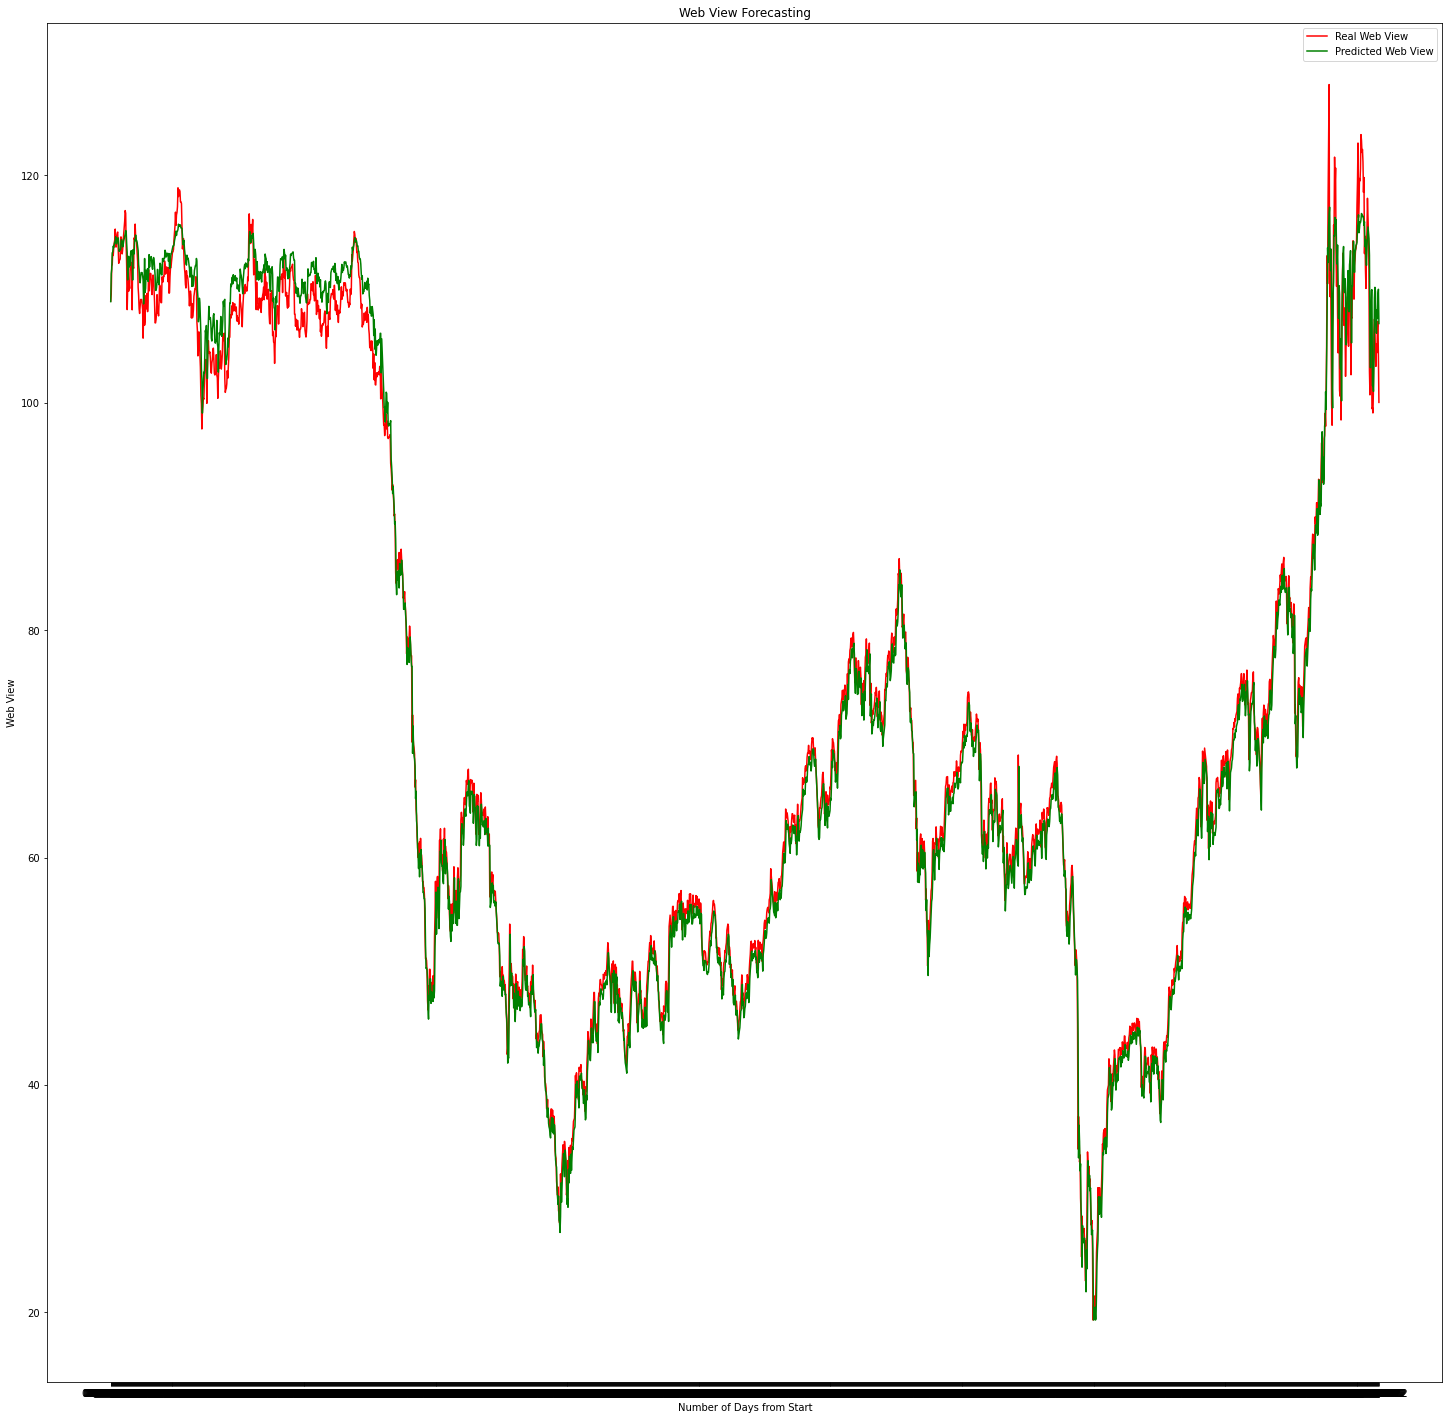

In [36]:
# Getting the predicted Web View
inputs = X
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (2547,1,1))
y_pred = best_model.predict(inputs)
y_pred = sc.inverse_transform(y_pred)

#print(key)
    #Visualising Result
plt.figure(figsize=(25,25))
plt.plot(y, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'green', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()


In [37]:
mape=mean_absolute_percentage_error(X, y_pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(X, y_pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)


Mean Absolute Percentage Error 0.017123443338708202
Mean Squared Error 2.1262665738850375
RMSE 1.4581723402551008


7/7 [==============================] - 0s 8ms/step


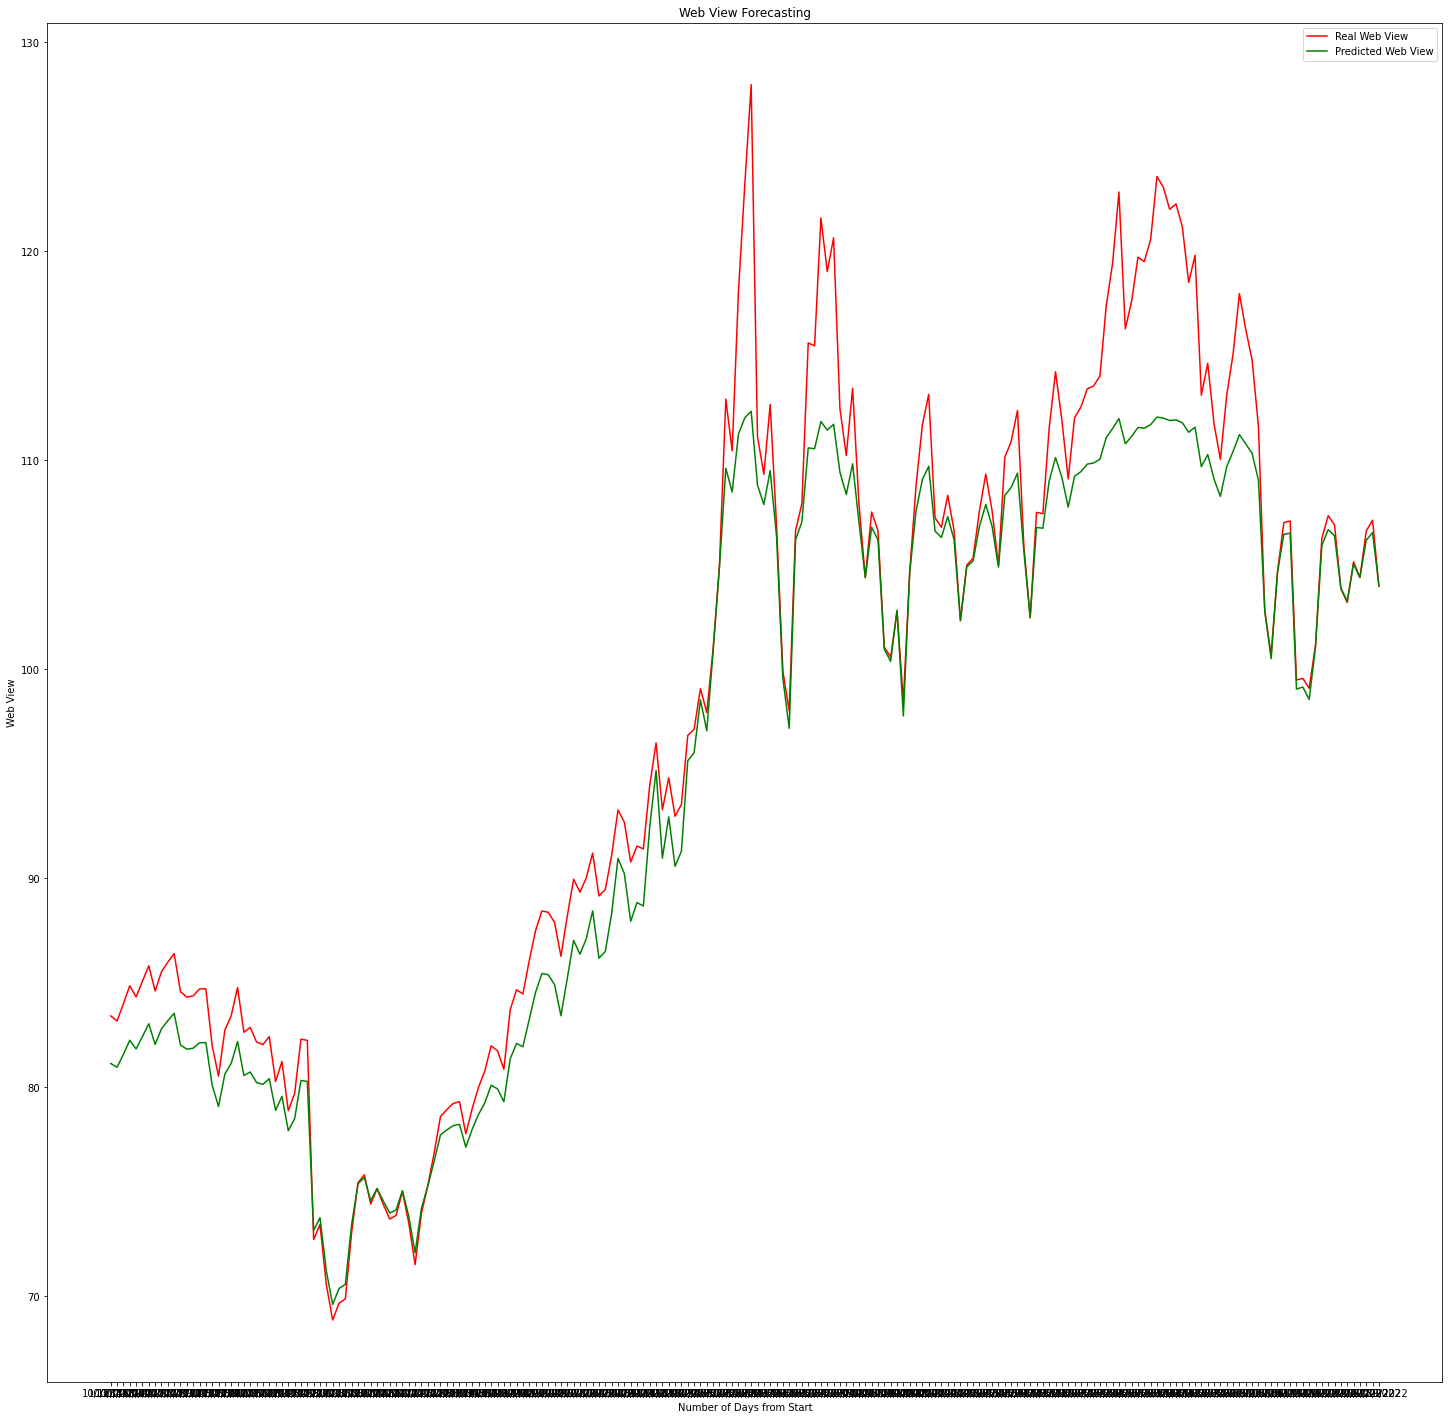

In [43]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(X_test),1,1))
y_pred_test = best_model.predict(inputs)
y_pred_test = sc.inverse_transform(y_pred_test)

    #Visualising Result
plt.figure(figsize=(25,25))
plt.plot(X_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred_test, color = 'green', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

In [44]:
mape=mean_absolute_percentage_error(X_test, y_pred_test)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(X, y_pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)

Mean Absolute Percentage Error 0.02340366456864304
Mean Squared Error 2.1262665738850375
RMSE 1.4581723402551008


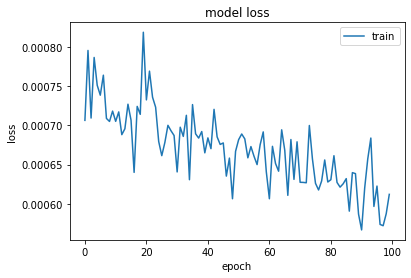

In [46]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/10
108/108 [==============================] - 3s 23ms/step - loss: 9.6576e-04 - mse: 9.6576e-04 - val_loss: 9603.6152 - val_mse: 9603.6152
Epoch 2/10
108/108 [==============================] - 2s 23ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 9617.0986 - val_mse: 9617.0986
Epoch 3/10
108/108 [==============================] - 3s 24ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 9605.0342 - val_mse: 9605.0342
Epoch 4/10
108/108 [==============================] - 3s 28ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 9605.1914 - val_mse: 9605.1914
Epoch 5/10
108/108 [==============================] - 3s 29ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 9600.8037 - val_mse: 9600.8037
Epoch 6/10
108/108 [==============================] - 3s 24ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 9599.6895 - val_mse: 9599.6895
Epoch 7/10
108/108 [==============================] - 2s 23ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 9598.1602 - val_mse: 9598.1602
Epoch 8/10
108/108 

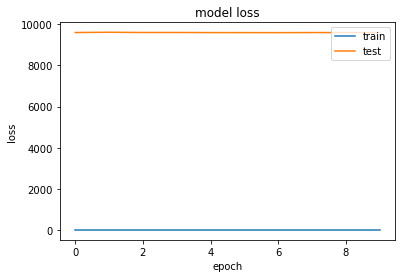

In [50]:

# fit network
history = best_model.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_test,y_test), verbose=1, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()